# Chapter 2: More Image Restoration and Image Inpainting

## Problems

1. Denoising with **AutoEncoders**    
   1.1: **Sparse Denoising AutoEncoder**   
   1.2: Denoising with **Convolution AutoEncoder** with **Skip Connection**       
   1.3: Deraining with **Gated Context Agreegation** Network (**GCANet**)    
3. Blind Deblurring with **DeblurGAN**
4. Image Inpainting    
   3.1: Inpainting with `opencv-python`   
   3.2: Inpainting with `scikit-learn` **k-NN** Regresson model       
5. Image Denoising with **Anisotropic Diffusion** with `opencv-python`
6. Deep Image Painting with `tensorflow.keras` 
7. Semantic Image Inpainting with **DCGAN**

## Problem 1: Denoising with AutoEncoders

An autoencoder is a neural network that learns a representation of input data (using its hidden layers $h_{W,b}(x) ≈ x$) in an unsupervised manner. In other words, it learns an approximation to the identity function, so that the output $\hat{x}$ is similar to input $x$ (as shown in the next figure). By placing constraints on the network, e.g., by having a much smaller number of hidden units (than the input), we can discover interesting structure in the input data (e.g., learn a compressed representation in the hidden units and then reconstruct the output).

![](images/ae.png)

A **denoising autoencoder** is a stochastic version of an autoencoder that takes inputs corrupted by noise and then trained to recover the original inputs in order to learn a good representation. We can use denoising autoencoders to learn robust representations from a set of similar input images (corrupted with noise) and then generate the denoised images.

### 1.1: Sparse Denoising AutoEncoder

In sparse autoencoder, a **sparsity constraint** is imposed on the hidden units and the autoencoder is trained to discover interesting structure in the input. When the output value of a *hidden neuron* is close to $1$, it can be considered to be *active* (*firing*), to the contrary, if its output value is close to $0$, it's consider *inactive*. The constraint is to keep the hidden neurons to be inactive most of the time. If $a^{(2)}_{j}(x)$ denotes the activation of the $j^{th}$ hidden unit when the network is given a specific input $x$ and the average activation of hidden unit $j$ is deonted by $\hat{\rho}_{j}=\frac{1}{m}\sum\limits_{i=1}^{m}a_j^{(2)}x^{(i)}$, the constraint enforced is $\hat{\rho}_{j} = \rho$, where the *hyperparameter* $\rho$ represents *sparsity*, and it is typically assgined to a very small value close to $0$ (e.g., $\rho = 0.05$).

In order to satisfy the *sparsity* constraint, the majority of the hidden unit's activations must be around $0$ and thus an extra *penalty term* is added to the *optimization objective function* that penalizes $\hat{\rho}_{j}$ deviating significantly from $\rho$, e.g., the following *Kullback-Leibler* (KL) divergence term for each hidden unit $j$:

$$KL(\rho||\hat{\rho}_j)=\rho \log{\frac{\rho}{\hat{\rho}_j}}+(1-\rho) \log{\frac{1-\rho}{1-\hat{\rho}_j}}$$

This penalty function has the property that $KL(ρ||\hat{ρ}_j) = 0$ minimum when $\hat{ρ}_j = ρ$ and otherwise it increases monotonically as $\hat{ρ}_j$ diverges from $ρ$. Hence, when this penalty term is minimized it will force $\hat{\rho}_j$ to be close to $ρ$. The overall cost function is 

$$J_{sparse}(W,b)=J(W,b)+\beta\sum\limits_{j=1}^{s_2}KL(\rho||\hat{\rho}_j)$$,

where $s_2$ is the size of the hidden layer $L_2$ (number of hidden units) and $W$, $b$ represents the weights and bias parameters that are learnt with back-propagation of the loss, with $β$ being a *hyperparameter* controlling the
penalty (*sparsity*) term's weight.

In this section we shall learn how to implement a **sparse denoising autoencoder** with *tensorflow*, starting with noisy version of *notMNIST* input images (of english alphabets) and recover the clean input images using the autoencoder. 

As usual, let's start by importing the required python libraries. Note that we shall use the features of tensorflow v1 an disable the eager execition for v2.

In [5]:
import tensorflow as tf
print(tf.__version__)
# 2.6.0
tf.compat.v1.disable_eager_execution()
import math
import matplotlib.pyplot as plt
import os
import numpy as np
from cv2 import imread

2.6.0


In [52]:
def read_images(dataset_path = 'images/notmnist'):
    images = []
    labels = []
    label = 0
    classes = sorted(os.walk(dataset_path).__next__()[1])
    for c in classes:
        c_dir = os.path.join(dataset_path, c)
        walk = os.walk(c_dir).__next__()
        for sample in walk[2]:
            if sample.endswith('.png'):
                try:
                    image = imread(os.path.join(c_dir, sample), 0)
                    images.append(image.ravel())
                    labels.append(c)
                except:
                    None
        label += 1    
    images = np.asarray(images, dtype=np.uint8)
    return images

In [ ]:
def kl_divergence(p, p_hat):
    return p * tf.math.log(p) - p * tf.math.log(p_hat) + (1 - p) * tf.math.log(1 - p) - (1 - p) * tf.math.log(1 - p_hat)

In [ ]:
x_train = read_images()
x_train = x_train / x_train.max()
np.random.shuffle(x_train)

In [ ]:
p = 0.01
learning_rate = 1e-3
epochs = 40
batch_size = 100
reg_term_lambda = 2*1e-3
beta = 3
n = 784 
n_hidden = 200

In [ ]:
x = tf.compat.v1.placeholder(tf.float32, [None, n])
x_noisy = tf.compat.v1.placeholder(tf.float32, [None, n])
xhat= tf.compat.v1.placeholder(tf.float32, [None, n])

W1 = tf.Variable(tf.random.normal([n, n_hidden], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([n_hidden]), name='b1')

W2 = tf.Variable(tf.random.normal([n_hidden, n], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([n]), name='b2')

linear_layer_one_output = tf.add(tf.matmul(x_noisy, W1), b1)
layer_one_output = tf.nn.sigmoid(linear_layer_one_output)

linear_layer_two_output = tf.add(tf.matmul(layer_one_output,W2),b2)
xhat = tf.nn.sigmoid(linear_layer_two_output)

mse_loss = (xhat - x)**2

p_hat = tf.reduce_mean(tf.clip_by_value(layer_one_output,1e-10,1.0),axis=0)
kl = kl_divergence(p, p_hat)

cost = tf.reduce_mean(tf.reduce_sum(mse_loss,axis=1)) + \
                      reg_term_lambda*(tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)) + \
                      beta*tf.reduce_sum(kl)
optimiser = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(cost)
init_op = tf.compat.v1.global_variables_initializer()

In [ ]:
losses = []
with tf.compat.v1.Session() as sess:
   sess.run(init_op)
   total_batch = int(len(y_train) / batch_size)
   cur = 0
   for epoch in range(epochs):
        mean_cost = 0
        for i in range(total_batch):
            batch_x = x_train[cur:cur+batch_size] 
            noise = np.random.normal(0, 0.15, batch_x.shape)
            batch_x_noisy = batch_x + noise
            _, c = sess.run([optimiser, cost], feed_dict={x: batch_x, x_noisy: batch_x_noisy})
            mean_cost += c / total_batch
        losses.append(mean_cost)
        if((epoch + 1) % 10 == 0):
           input_images = batch_x
           noisy_image = batch_x_noisy
           weight_images = W1.eval(sess).transpose()
           output_images = xhat.eval(feed_dict={x: batch_x, x_noisy: batch_x_noisy}, session=sess)
           # plot images here
        cur += batch_size

* Plot the loss function values to see the decay over epochs (left as an exercise, insert your code at line $20$ in the above code snippet). 
* Plot the original and noisy inputs, the weights learnt and the denoised output (e.g., every 10 epochs). 

The following figure shows the output that you could after 40 epochs, note the images denoised by the autoencoder prediction:

![](images/loss_sdae.png)
![](images/in_sdae.png)
![](images/out_sdae.png)

### 2.2: Denoising with Convolution AutoEncoder with Skip Connection

In this problem, you will learn to use a very deep *fully convolutional* *Residual* *auto-encoder* neural network (called **RED-Net**) for image denoising and restoration. The network is composed of multiple *convolution* and *transposed-convolution* layers, enabling it to learn *end-to-end mappings* from *corrupted* images (provided as input) to *denoised* original images (to be produced as output). The *convolution* layers eliminate corrputions by capturing the *abstraction* of image contents. Transposed-convolutional layers are used to recover the image details by upsampling the feature maps [1]. 

To avoid difficulty in training, convolutional and transposed-convolutional layers are symmetrically linked with skip-layer connections (as shown in the following figure), to get the training converge faster with better results. 

![](images/rednet_arch.png)

The skip connections from convolutional layers to their mirrored corresponding transposed-convolutional layers exhibit the following couple of advantages: 
* it handles the vanishing gradient problem while back-propagation 
* the skip connections pass image details from convolutional layers to transposed-convolutional layers, which is beneficial in recovering the clean image.

Again, we shall implement the deep learning model with `tensorflow` and this time we shall use `keras` library functions. Let;s start by importing the required libraries.

In [ ]:
import tensorflow as tf
from keras import layers, models, initializers
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
def rednet(depth=20, n_filters=128, kernel_size=(3, 3), skip_step=2, n_channels=1):
    num_connections = np.ceil(depth / (2 * skip_step)) if skip_step > 0 else 0
    x = layers.Input(shape=[None, None, n_channels], name="InputImage")
    y = x
    encoder_layers = []
    with tf.name_scope("REDNet"):
        for i in range(depth // 2):
            with tf.name_scope("EncoderLayer{}".format(i + 1)):
                y = layers.Conv2D(n_filters, kernel_size=kernel_size,
                                  kernel_initializer=initializers.glorot_uniform(),
                                  padding="same", activation=None, use_bias=False,
                                  name="Layer{}_Conv".format(i + 1))(y)
                y = layers.BatchNormalization(name="Layer{}_BatchNorm".format(i + 1))(y)
                y = layers.ReLU(name="Layer{}_Actv".format(i + 1))(y)
                encoder_layers.append(y)
        j = int((num_connections - 1) * skip_step)  # Encoder layers count
        k = int(depth - (num_connections - 1) * skip_step)  # Decoder layers count
        for i in range(depth // 2 + 1, depth):
            with tf.name_scope("DecoderLayer{}".format(i + 1)):
                y = layers.Conv2DTranspose(n_filters, kernel_size=kernel_size,
                                           kernel_initializer=initializers.glorot_uniform(),
                                           padding="same", activation=None, use_bias=False,
                                           name="Layer{}_Conv".format(i))(y)
                y = layers.BatchNormalization(name="Layer{}_BatchNorm".format(i))(y)
                if i == k:
                    y = layers.Add(name="SkipConnect_Enc_{}_Dec_{}".format(j, k))([encoder_layers[j - 1], y])
                    k += skip_step
                    j -= skip_step
                y = layers.ReLU(name="Layer{}_Actv".format(i))(y)
        with tf.name_scope("OutputLayer"):
            y = layers.Conv2DTranspose(1, kernel_size=kernel_size,
                                       kernel_initializer=initializers.glorot_uniform(),
                                       padding="same", activation=None, use_bias=False,
                                       name="Output_Conv")(y)
            y = layers.BatchNormalization(name="Output_BatchNorm")(y)
            y = layers.Add(name="SkipConnect_Input_Output")([x, y])
            y = layers.ReLU(name="Output_Actv")(y)
    return models.Model(inputs=[x], outputs=[y])

rednet30 = rednet(30, n_channels=3)

In [117]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255
x_test = x_test / 255
np.random.shuffle(x_train)
noise = np.zeros(x_train.shape)
for i in range(x_train.shape[-1]):
    noise[..., i] = np.random.normal(0, 0.1, size=x_train.shape[:-1])
x_train_noisy = x_train + noise
noise = np.zeros(x_test.shape)
for i in range(x_test.shape[-1]):
    noise[..., i] = np.random.normal(0, 0.1, size=x_test.shape[:-1])
x_test_noisy = x_test + noise

In [ ]:
rednet30.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5*1e-6),  # Optimizer
    loss=tf.keras.losses.binary_crossentropy
)

history = rednet30.fit(
    x_train_noisy,
    x_train,
    batch_size=64,
    epochs=10)

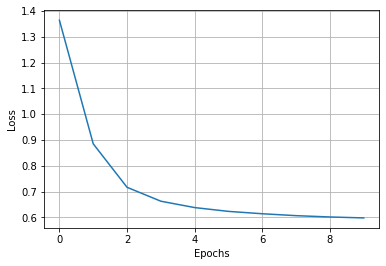

In [21]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.grid()
plt.xlabel('Epochs', size=10)
plt.ylabel('Loss', size=10)
plt.show()

In [ ]:
x_test_p = rednet30.predict(x_test_noisy)

<div>
<img src="images/Img_02_01.png" width="1000"/>
</div>
<div>
<img src="images/Img_02_02.png" width="1000"/>
</div>

### 1.3: Deraining with Gated Context Agreegation Network (GCANet)

In this problem we shall focus on *deraining* an image using a *pre-trained* deep learning model (*dehazing* network), i.e. the input will be an image in a *rainy* environment and the output will be one without the *rain-streak* component. Given a hazy input image, the *dehazing* network tries to retrieve the uncorrupted content. Again, instead of using traditional handcrafted or low-level *image priors* as the *constraints* for *handcrafted*, the output *haze-free* image will be directly restored using an *end-to-end* deep neural net named *gated context aggregation network* (**GCANet**). In this network, the latest *smoothed dilation technique* is used to get rid of the *gridding artifacts* caused due to the *dilated convolution*, and a *gated sub-network* will be used to fuse the features from different levels. The following figure shows the architecture of the deep neural net [3].
![](images/Img_02_04.png)

* Using the *encoder*, a *hazy* input image is encoded into the feature maps. Next more context information is aggregated and  features from different levels are fused (without downsampling) to enhance the feature maps. 
* *Smoothed dilated convolution* (implemented using *dilated convolutional layer*) and an extra *gated sub-network* are used. 
* The *target haze residue* is computed after *decoding* the enhanced feature maps back to original image space. Next the *residue* obtained is added to the *hazy* input image, the final *haze-free* image is obtained.
* The feature maps from different levels $F_l, F_m, F_h$ are extracted and fed into the gated fusion subnetwork. Three different *importance weights*, namely, ($M_l,M_m,M_h$) are output by the *gated fusion sub-network* (corresponding to the three feature levels, respectively). Finally, the *regressed importance weights* obtained are used to (linearly) combine these three features maps from different levels.

Let's implement the model this time using `pytorch`, start by importing the libraries needed.

In [599]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from PIL import Image
import os

In [602]:
class ShareSepConv(nn.Module):
    def __init__(self, kernel_size):
        super(ShareSepConv, self).__init__()
        assert kernel_size % 2 == 1, 'kernel size should be odd!'
        self.padding = (kernel_size - 1) // 2
        weight_tensor = torch.zeros(1, 1, kernel_size, kernel_size)
        weight_tensor[0, 0, (kernel_size - 1) // 2, (kernel_size - 1) // 2] = 1
        self.weight = nn.Parameter(weight_tensor)
        self.kernel_size = kernel_size

    def forward(self, x):
        inc = x.size(1)
        expand_weight = self.weight.expand(inc, 1, self.kernel_size, self.kernel_size).contiguous()
        return F.conv2d(x, expand_weight, None, 1, self.padding, 1, inc)


class SmoothDilatedResidualBlock(nn.Module):
    def __init__(self, num_channels, dilation=1, groups=1):
        super(SmoothDilatedResidualBlock, self).__init__()
        self.pre_conv1 = ShareSepConv(dilation*2 - 1)
        self.conv1 = nn.Conv2d(num_channels, num_channels, 3, 1, padding=dilation, dilation=dilation, groups=groups, bias=False)
        self.norm1 = nn.InstanceNorm2d(num_channels, affine=True)
        self.pre_conv2 = ShareSepConv(dilation*2 - 1)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 3, 1, padding=dilation, dilation=dilation, groups=groups, bias=False)
        self.norm2 = nn.InstanceNorm2d(num_channels, affine=True)

    def forward(self, x):
        y = F.relu(self.norm1(self.conv1(self.pre_conv1(x))))
        y = self.norm2(self.conv2(self.pre_conv2(y)))
        return F.relu(x+y)


class ResidualBlock(nn.Module):
    def __init__(self, num_channels, dilation=1, groups=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, 3, 1, padding=dilation, dilation=dilation, groups=groups, bias=False)
        self.norm1 = nn.InstanceNorm2d(num_channels, affine=True)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 3, 1, padding=dilation, dilation=dilation, groups=groups, bias=False)
        self.norm2 = nn.InstanceNorm2d(num_channels, affine=True)

    def forward(self, x):
        y = F.relu(self.norm1(self.conv1(x)))
        y = self.norm2(self.conv2(y))
        return F.relu(x+y)

In [ ]:
class GCANet(nn.Module):
    def __init__(self, in_c=4, out_c=3, only_residual=True):
        super(GCANet, self).__init__()
        self.conv1 = nn.Conv2d(in_c, 64, 3, 1, 1, bias=False)
        self.norm1 = nn.InstanceNorm2d(64, affine=True)
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1, bias=False)
        self.norm2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = nn.Conv2d(64, 64, 3, 2, 1, bias=False)
        self.norm3 = nn.InstanceNorm2d(64, affine=True)

        self.res1 = SmoothDilatedResidualBlock(64, dilation=2)
        self.res2 = SmoothDilatedResidualBlock(64, dilation=2)
        self.res3 = SmoothDilatedResidualBlock(64, dilation=2)
        self.res4 = SmoothDilatedResidualBlock(64, dilation=4)
        self.res5 = SmoothDilatedResidualBlock(64, dilation=4)
        self.res6 = SmoothDilatedResidualBlock(64, dilation=4)
        self.res7 = ResidualBlock(64, dilation=1)

        self.gate = nn.Conv2d(64 * 3, 3, 3, 1, 1, bias=True)
        
        self.deconv3 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.norm4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.norm5 = nn.InstanceNorm2d(64, affine=True)
        self.deconv1 = nn.Conv2d(64, out_c, 1)
        self.only_residual = only_residual

    def forward(self, x):
        y = F.relu(self.norm1(self.conv1(x)))
        y = F.relu(self.norm2(self.conv2(y)))
        y1 = F.relu(self.norm3(self.conv3(y)))
        y = self.res1(y1)
        y = self.res2(y)
        y = self.res3(y)
        y2 = self.res4(y)
        y = self.res5(y2)
        y = self.res6(y)
        y3 = self.res7(y)

        gates = self.gate(torch.cat((y1, y2, y3), dim=1))
        gated_y = y1 * gates[:, [0], :, :] + y2 * gates[:, [1], :, :] + y3 * gates[:, [2], :, :]
        y = F.relu(self.norm4(self.deconv3(gated_y)))
        y = F.relu(self.norm5(self.deconv2(y)))
        if self.only_residual:
            y = self.deconv1(y)
        else:
            y = F.relu(self.deconv1(y))

        return y

In [603]:
def edge_compute(x):
    x_diffx = torch.abs(x[:,:,1:] - x[:,:,:-1])
    x_diffy = torch.abs(x[:,1:,:] - x[:,:-1,:])
    y = x.new(x.size())
    y.fill_(0)
    y[:,:,1:] += x_diffx
    y[:,:,:-1] += x_diffx
    y[:,1:,:] += x_diffy
    y[:,:-1,:] += x_diffy
    y = torch.sum(y,0,keepdim=True)/3
    y /= 4
    return y

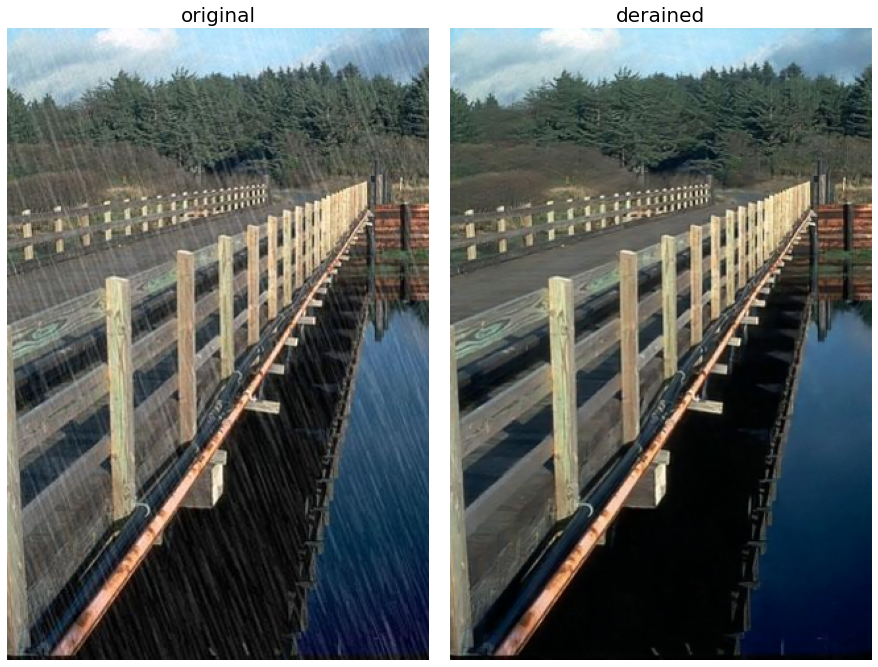

In [608]:
#task = 'derain'
model = 'models/wacv_gcanet_derain.pth' 

net = GCANet(in_c=4, out_c=3, only_residual=False)
net.float()
net.load_state_dict(torch.load(model, map_location='cpu'))
net.eval()

img_path = 'images/Img_02_03.jpg'
img = Image.open(img_path).convert('RGB')
im_w, im_h = img.size
if im_w % 4 != 0 or im_h % 4 != 0:
    img = img.resize((int(im_w // 4 * 4), int(im_h // 4 * 4))) 
img = np.array(img).astype('float')

img_data = torch.from_numpy(img.transpose((2, 0, 1))).float()
edge_data = edge_compute(img_data)
in_data = torch.cat((img_data, edge_data), dim=0).unsqueeze(0) - 128 
in_data = in_data.float()

with torch.no_grad():
    pred = net(Variable(in_data))
out_img_data = pred.data[0].cpu().float().round().clamp(0, 255)
out_img = Image.fromarray(out_img_data.numpy().astype(np.uint8).transpose(1, 2, 0))

plt.figure(figsize=(12,10))
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
plt.subplot(121), plt.imshow(img.astype(int)), plt.axis('off'), plt.title('original', size=20)
plt.subplot(122), plt.imshow(out_img), plt.axis('off'), plt.title('derained', size=20)
plt.show()

### Problem 2: Blind Deblurring with DeblurGAN

In this section we shall learn how to solve blind motion deblurring of a single photograph using an end-to-end generative deep learning model called **DeblurGAN**. The learning is based on a *conditional Generative Adversarial Network (GAN)* and the *content loss*. As described in the first chapter, the family of deblurring problems is divided into two types:
*blind* and *non-blind deblurring*, without and with an assumption that the blur kernel is known, respectively. When the blur function is unknown, and blind deblurring algorithms estimate both latent sharp image IS and blur kernel (as *Richardson-Lucy* algorithm, implemented in chapter $1$). 

**Generative adversarial network** (**GAN**), a form of *unsupervised machine learning*, trains two competing networks, namely, the **discriminator** and the **generator** simultaneouly, as shown in the next figure. 

* The generator $G$ receives noise as an input and generates a sample. The goal of the generator is to fool the discriminator by generating perceptually convincing samples that can not be distinguished from the real one.
* The discriminator $D$ receives a real and generated (fake) sample and tries to distinguish between them. The goal of the discriminator is to detect the fake image generated, it learns a **binary classifier**, outputing $1$ when the input is a *real* image and $0$ in case of a *fake* one. 

![](images/gan_arch.png)

If $x$ be a **real** image and $\tilde{x}$ be a **fake** image generated by $G$ (from noise $z$, by $\tilde{x}=G(z)$), 

* The discriminator $D$ tries to maximize $D(x)$ and minimize $D(\tilde{x})$ (or equivalently maximize $1-D(\tilde{x})$) to detect  *fake* images generated by $G$.
* The generator $G$ tries to maximize $D(\tilde{x})$ (or equivalently minimize $1-D(\tilde{x})$) to fool $D$. 

Hence, the game between the generator $G$ and discriminator $D$ then can be formulated by the following *minimax* objective (in the $\log{}$ space), also called *adversarial loss*: 

$$\underset{G}{min} \; \underset{D}{max} \; \underset{x \sim P_r}{E}[log(D(x))] + \underset{\tilde{x} \sim P_g}{E}[log(1 - D(\tilde{x}))]$$

where $P_r$ is the data distribution and $P_g$ is the model distribution, defined by $\tilde{x} = G(z)$, the input $z$
is a sample from a simple noise distribution and $G(z)$ is the (fake) image output by the generator given input $z$. $D(x)$ is the discriminator's estimate of the probability that real data instance $x$ is real. GANs are known for its ability to generate samples of good perceptual quality.

**Conditional GAN** is an extension of the **GAN** framework. An additional conditional information $C$ is input to both discriminator and generator (as shown in the next figure) that describes some aspect of the images (e.g., if it's MNIST images, $C$ could describe the digit class / label). This attribute information is inserted in both the generator and the discriminator. Hence, when the adversarial training is over, the generator can generate a digit of a specific class when asked. Unlike vanilla *GAN*, *conditional GAN* (**cGAN**) learns a mapping from observed image $x$ and random noise vector $z$, to $y$ , $G : x, z → y$. 

<img src="images/cgan_arch.png" width="750"/>


The goal of **DeblurGAN** is to recover sharp image $I_S$ given only a blurred image $I_B$ as an input, without any information about the blur kernel. Debluring is done by the trained CNN $G_{θ_G}$, which acts the Generator. For each $I_B$ it estimates corresponding $I_S$ image. In addition, during the training phase, the critic network $D_{θ_D}$ is introduced and
both networks are trained in an adversarial manner. The loss function is formulated as a combination of content and adversarial loss:  
$$\mathcal{L} = \underbrace{\underbrace{\mathcal{L_{GAN}}}_{adversarial\;loss} + \underbrace{\lambda\mathcal{L_{X}}}_{content\; loss}}_{total\; loss}$$

The next figure shows the architecture of the generator network $G$.

![](images/dcgan_arch.png)

As can be seen from the above figure, it contains two strided convolution blocks with stride 1/2, nine residual blocks (`ResBlocks`) and two transposed convolution blocks. Each `ResBlock` consists of a convolution layer, instance normalization layer, and `ReLU` activation. `Dropout` regularization with a probability of $0.5$ is added after the first convolution layer in each `ResBlock`. In addition, a global skip connection is introduced which is referred to as `ResOut`. CNN learns a residual correction $I_R$ to the blurred image $I_B$, so $I_S = I_B + I_R$. It's found that such formulation makes training faster and resulting model generalizes better [2]. 

Let's start our implementation by importing all the required libraries, using the following code block.

In [100]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, Add, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import LeakyReLU, Conv2D, Dense, Flatten, Lambda, InputSpec, Layer
from tensorflow.keras.models import Model
import tensorflow.keras.utils as conv_utils
import tensorflow.keras.backend as K
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
from glob import glob

In [120]:
data_format = K.image_data_format()

def res_block(input, filters, kernel_size=(3, 3), strides=(1, 1), dropout=False):
    
    x = ReflectionPadding2D((1, 1))(input)
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if dropout:
        x = Dropout(0.5)(x)

    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,)(x)
    x = BatchNormalization()(x)

    merged = Add()([input, x])
    return merged

def normalize_tuple(value, n):    
    return (value,) * n if isinstance(value, int) else tuple(value)

def spatial_reflection_2d_padding(x, padding=((1, 1), (1, 1))):
    #assert len(padding) == 2  & len(padding[0]) == 2 & len(padding[1]) == 2
    pattern = [[0, 0], list(padding[0]), list(padding[1]), [0, 0]]
    return tf.pad(x, pattern, "REFLECT")

class ReflectionPadding2D(Layer):

    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.data_format = data_format
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif hasattr(padding, '__len__'):
            # assert len(padding) == 2:
            height_padding = normalize_tuple(padding[0], 2)
            width_padding = normalize_tuple(padding[1], 2)
            self.padding = (height_padding, width_padding)
        
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        rows = input_shape[1] + self.padding[0][0] + self.padding[0][1] if input_shape[1] is not None else None
        cols = input_shape[2] + self.padding[1][0] + self.padding[1][1] if input_shape[2] is not None else None
        return (input_shape[0], rows, cols, input_shape[3])

    def call(self, inputs):
        return spatial_reflection_2d_padding(inputs, padding=self.padding)

    def get_config(self):
        config = {'padding': self.padding, 'data_format': self.data_format}
        base_config = super(ReflectionPadding2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [121]:
n_blocks_gen = 9

def generator_model():
    
    inputs = Input(shape=(256, 256, 3))

    x = ReflectionPadding2D((3, 3))(inputs)
    x = Conv2D(filters=ngf, kernel_size=(7, 7), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        x = Conv2D(filters=ngf*mult*2, kernel_size=(3, 3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    mult = 2**n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf*mult, use_dropout=True)

    for i in range(n_downsampling):
        mult = 2**(n_downsampling - i)
        # x = Conv2DTranspose(filters=int(ngf * mult / 2), kernel_size=(3, 3), strides=2, padding='same')(x)
        x = UpSampling2D()(x)
        x = Conv2D(filters=int(ngf * mult / 2), kernel_size=(3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(filters=output_nc, kernel_size=(7, 7), padding='valid')(x)
    x = Activation('tanh')(x)

    outputs = Add()([x, inputs])
    outputs = Lambda(lambda z: z/2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name='Generator')
    return model

In [122]:
def load_image(path):
    img = Image.open(path)
    return img

def preprocess_image(img):
    img = img.resize((256,256))
    img = np.array(img)
    img = (img - 127.5) / 127.5
    return img

def deprocess_image(img):
    img = img * 127.5 + 127.5
    return img.astype('uint8')

def deblur(blurred, model_path):
    x_test_lst = [preprocess_image(blurred)]
    batch_size = len(x_test_lst)
    x_test = np.array(x_test_lst)
    g = generator_model()
    g.load_weights(model_path)
    generated_images = g.predict(x=x_test, batch_size=1)
    generated = np.array([deprocess_image(img) for img in generated_images])[0]
    return generated

orig, blurred = load_image('images/Img_02_04.jpg'), load_image('images/Img_02_21.jpg')
deblurred = deblur(blurred, 'models/generator.h5')

If you plot the original, blurred and the deblurred (with DeblurGAN) images, you should get the following output figure.

![](images/deblurGAN_out.png)

### Problem 3: Image Inpainting 

Image inpainting is a form of image restoration and conservation, the technique is generally used to repair images with missing areas. Given an image and a (corrupted) region $\Omega$ inside it, the goal of an image inpainting method is to modify the pixel values inside $Ω$, s.t. this inpainted region does not stand out w.r.t. its neighboring regions (surroundings). The goal of inpainting is either to restore damaged portions or to remove unwanted elements present in an input image. The region $Ω$ is provided by the user, with a binary mask (where the white / black pixels represent the damaged / undamaged part of the image, respectively, or sometimes the other way around). In this section we shall learn how to apply a few inpainting techniques to restore the damaged parts of an input image, first using a few variational methods with the library `opencv-python` and then using a machine-learning based method using `scikit-learn` library.

### 3.1: Inpainting with opencv-python

There are several algorithms out there for digital image inpainting, but *opencv* natively provides implementations for a few of them, namely,

* `INPAINT_TELEA`: This algorithm uses **Fast Marching Method** (*FMM*) for inpainting the corrupted region in an image. The algorithm starts from the boundary of the region to be inpainted and then proceeds gradually inside the region. It first fills everything in the boundary. A pixel (to be inpainted) is replaced by the (normalized) weighted sum of all known pixels in a small neighborhood around it (nearby pixels in the neighborhood / near the normal of the boundary / on the boundary contours get more weightage). After the pixel gets inpainted, it goes to the next nearest pixel to be inpainted, by using the *Fast Marching Method* (by treating the region to be inpainted as level sets). 

* `INPAINT_NS`: This algorithm is based on *fluid dynamics* and is called **Navier-Stokes** based Inpainting. It is a heurisitic-based algorithm, with couple of constraints: 1) preserve gradients and 2) continue to propagate color information in smooth regions. Partial differential equations (**PDE**) are used to update image intensities inside the region with the constraints. It travels from *known* to *unknown* regions along the edges first (to maintain the continuity of the edges). It propagates image smoothness information (estimated by the *Laplacian*) along the *isophotes* (contour line joining pixels with same intensity), at the same time matches the *gradients* at the boundary of region to be inpainted. 

* `INPAINT_SHIFTMAP`: This algorithm searches for dominant correspondences (transformations) of image patches and tries to seamlessly fill-in the area to be inpainted using this transformations.

* `INPAINT_FSR`: This algorithm uses **Frequency Selective Reconstruction** (**FSR**), which is a high-quality signal extrapolation algorithm. Successively, the signal of a distorted block is extrapolated using known samples and
already reconstructed pixels as support. An important feature of FSR is the fact that the calculations are carried out in the
Fourier domain, which leads to a fast implementation. This further has two quality profiles, one of the them needs to be chosen, depending on how fast we need the *reconstruction*, they are: `INPAINT_FSR_FAST` and `INPAINT_FSR_BEST`.

In this section we shall simply use the above `opencv-python` implementations to inpaint an image distored by adding a random pattern.

* We shall compare the quality of the inpainted outputs obtained with different algorithms using the following two metrics, namely, 

    * *peak-signal-to-noise-ratio* (**PSNR**):  *PSNR* between original image $f$ and reconstructed image $\hat{f}$ is expressed as: 
$$\text{PSNR}(f, \hat{f}) = 10 \log_{10} \frac{\left(\text{MAX}({\hat{f}})\right)^2}{\text{MSE}(f, \hat{f})}$$ 
here $\text{MAX}({\hat{f}})=255$ for a grayscale image of type `uint8` and *mean-square-error* *MSE* is defined as  
$$\text{MSE}(f, \hat{f}) = \frac{\|f-\hat{f}\|_F^2}{s}$$ 
where $F$ represents the *Frobeneous norm* of the error image matrix $(f - \hat{f})$  and $s$ is size of image $f$ ($s=$number of pixels).  *PSNR* is a representation of absolute error in *dB*.
    * *structural similarity index method* (**SSIM**): In this perception-based model, image *degradation* is apprehended as perception-change in structural-information. **SSIM** is defined by [9]

    $$\text{SSIM}(f, \hat{f}) = [l(f,\hat{f})]_α⋅[c(f,\hat{f})]_β⋅[s(f,\hat{f})]_γ=\frac{\left(2\mu_f\mu_{\hat{f}}+M_1\right)\left(2cov(f, \hat{f})+M_2\right)}{\left(\mu_f^2+\mu_{\hat{f}}^2+M_1\right)\left(\sigma_f^2+\sigma_{\hat{f}}^2+M_2\right)}$$

   Here, $\mu$, $\sigma$ and $cov$ respesent the *mean*, *stadard deviation* and *covariance* of the images, $M_1={(E_1F)}^2$ and $M_2={(E_2F)}^2$, where the values $E_1=0.01$, $E_2=0.003$ and $F=255$ are used for grayscale images.

   Also, $l$ refers to *luminance* (brightness), $c$ refers to *contrast* (range between the darkest & the brightest regions) and $s$ refers to *structure* (*the local luminance pattern*), where $α$, $β$ and $γ$ are +ve constants.
    
    
* Let's start by importing the required libraries. Also, note the version of `opencv-python` (`cv2`).

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
print(cv2.__version__)

4.5.5


In [3]:
image_orig = cv2.imread('images/house.jpg') 
mask = cv2.imread('images/random_mask.jpg', 0)
thres = 128
mask[mask > thres] = 255
mask[mask <= thres] = 0
image_defect = image_orig.copy()
for layer in range(image_defect.shape[-1]):
    image_defect[np.where(mask)] = 0

In [4]:
images_rec = {}
for algo_name, algo_id in zip(['TELEA', 'NS'], [cv2.INPAINT_TELEA, cv2.INPAINT_NS]):
    images_rec[algo_name] = cv2.inpaint(image_defect, mask, 3, algo_id)

inverse_mask = (255 - mask) 
image_rec = np.zeros_like(image_defect, dtype=np.uint8)
for algo_name, algo_id in zip(['SHIFTMAP', 'FSR_FAST', 'FSR_BEST'], \
                              [cv2.xphoto.INPAINT_SHIFTMAP, cv2.xphoto.INPAINT_FSR_FAST, cv2.xphoto.INPAINT_FSR_BEST]):
    cv2.xphoto.inpaint(src=image_defect, mask=inverse_mask, dst=image_rec, algorithmType=algo_id)
    images_rec[algo_name] = image_rec.copy()

In [5]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def show_recovered_image(im_orig, im_rec, algo_name):
    plt.imshow(im_rec), plt.axis('off')
    plt.title('{} \n PSNR: {:.02f}, SSIM: {:.02f}'.format(
                                            algo_name,
                                            psnr(im_orig, im_rec),
                                            ssim(im_orig, im_rec, data_range=im_rec.max() - im_rec.min(), multichannel=True)), 
              size=20)

![](images/inpainting_out.png)

### 3.2: Inpainting with scikit-learn k-NN Regresson model

In this section, we shall formulate the image inpainting problem as a *supervised machine learning regression* problem. More specifically, we shall try to learn an approximate function $\hat{f}$ for the image function $f: x,y \to \mathcal{R}$, 

* by training a supervised machine learning model $\mathcal{M}_{\theta}$ that learns the function $\hat{f}$ (by updating its parameters $\theta$), by minimizing a loss function $\mathcal{L}(f(x,y),\hat{f}(x,y))$, for $(x,y) \in \bar{\Omega}$, i.e., for the region where the image is not corrupted ($\bar{\Omega}$).  For example, for model like *linear regression*,  we can use the sum-squared-error (*SSE*) / $L_2$ loss function defined by $\|f - \hat{f}\|_2^2$ or equivalently the *mean-squared-error* (*MSE*) obtained by dividing *SSE* by image size. 
* by using the model $\mathcal{M}_{\theta}$ we just trained (and the function $\hat{f}$ we just learnt), to predict the pixel values with $\hat{f}(x,y),\; \forall{(x,y)} \in \Omega$, for the region $\Omega$ to inpaint (i.e., where the image pixels are corrputed). 

* Here, we shall use the *k-nearnest-neighbor* (**k-NN**) regression model (`KNeighborsRegressor` from `scikit-learn` library's `neighbors` module) to learn the function $\hat{f}$, we can use any other regression model too (e.g., try the *ordinary least suqare linear regression* with *MSE* loss function and the *ensemble* model *random forest regression* and compare the results). 
* Let's import the required module / class and read the original input and the mask image as `np.uint8` arrays, using the following code snippet. 
* Note that here we are assuming that the input is a grayscale image and thus reading both the input and mask images with `cv2.imread` with mode flag as $0$ (i.e., `cv2.IMREAD_GRAYSCALE`). We can extend the implementation to inpaint an RGB color input image simply by learning a model for each color channel (see exercise problem $6$).
* Threshold the mask image (with a constant threshold $0.5$, e.g.) to obtain a binary mask (here the inpainting region $\Omega$ is defined by the white pixels in the mask), convert it to `boolean` array (lines $6-9$ in the code).
* Assuming that the white pixels in mask define the corrupted region, let's now create the degraded image (`image_defect`) by turnning the corresponding pixels off (lines $12-14$).

In [3]:
from sklearn.neighbors import KNeighborsRegressor

image_orig = cv2.imread('images/Img_02_05.jpg', 0) 
mask = cv2.imread('images/mask.jpg', 0)
mask = mask / mask.max()
thres = 0.5
mask[mask > thres] = 1
mask[mask <= thres] = 0
mask = mask.astype('bool')
#print(np.unique(mask))

image_defect = image_orig.copy()
for layer in range(image_defect.shape[-1]):
    image_defect[mask] = 0

In [6]:
x, y = np.meshgrid(range(image_orig.shape[1]), range(image_orig.shape[0]))
d = image_orig[y, x]
x_train, y_train, d_train = x[~mask], y[~mask], d[~mask]
x_test, y_test, d_test = x[mask], y[mask], d[mask]
    
image_out = np.zeros_like(image_orig)
d_pred = np.zeros_like(d_test)
model = KNeighborsRegressor() 
model.fit(np.vstack((x_train, y_train)).T, d_train)
d_pred = model.predict(np.vstack((x_test, y_test)).T)
image_out[~mask] = image_orig[~mask]
image_out[mask] = d_pred

Now, plot the original, corrupted and the inpaitned (recovered) image side by side. You should obtain a plot like the following figure. Note that the algorithm could succesfully inpaint the damaged image.

![](images/inpaint_knn_out_gray.png)

### Problem 4: Image Denoising with Anisotropic Diffusion with opencv-python

In this section, we shall learn how to use the anisotropic (heat) diffusion equation to denoise an image preserving the edges by using an extended image processing function from the library `opencv-python`. *Isotropic diffusion* is identical to applying a Gaussian filter, which blurs an image without preserving the edges in the image, as we have already seen. 

* *Anisotropic diffusion* can be used to smooth (denoise) an image by keeping the edges mostly unchanged (even sharpened). 
* It's *anisotropic* in the sense that the diffusion happens in different neighboring direction at different rates (depending on the presence of an edge or not), this is implemented by the *PDE* shown below, where the *conductivity* term used an edge stopping function (kernel) $g(.)$ to stop diffusion along sharp edges in the input. 
* The anisotropic diffusion process is an iterative process, the *Gaussian* kernel or an inverse-square kernel function $g(.)$ used as a conductivity function ($c$), according to *Perona-Malik equation 1* or *equation 2* [6, 7], respectively, as shown in the following figure:

![](images/aniso_diff.png)

Let's start the implementation by importing the required libraries, modules and functions.

In [38]:
import numpy as np
import matplotlib.pylab as plt
import cv2
print(cv2.__version__)
from skimage.io import imread
from skimage.util import random_noise

4.5.5


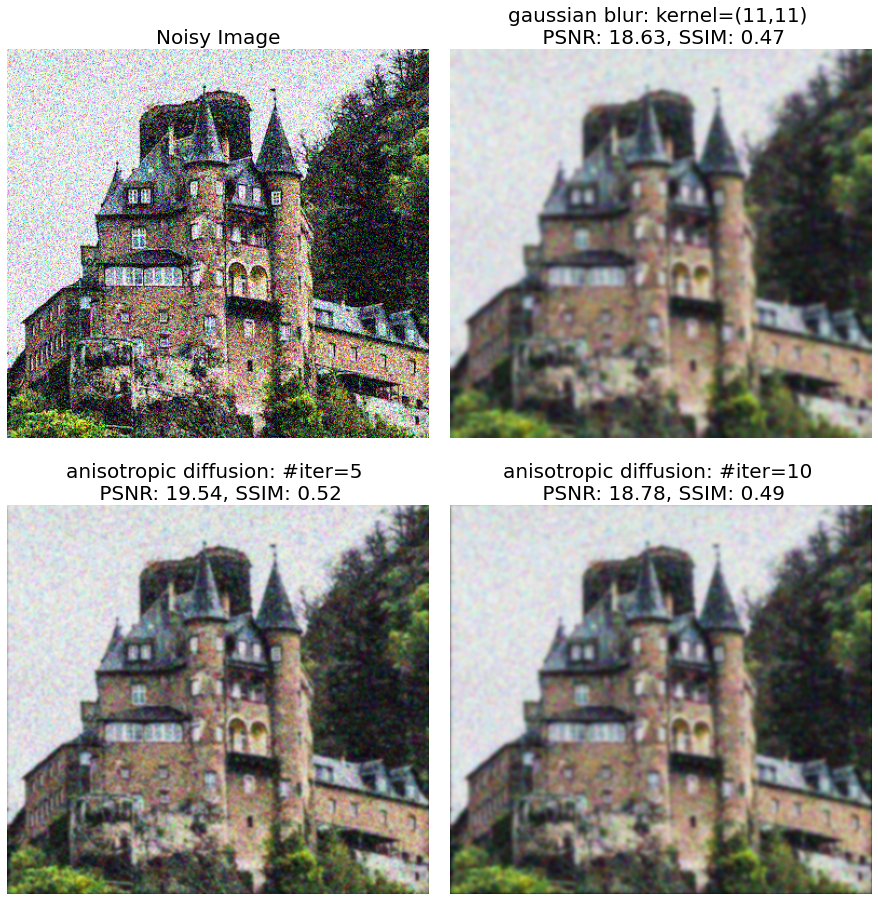

In [112]:
im = imread('images/scene2.jpeg')
noisy = (255*random_noise(im, var=0.05)).astype(np.uint8)

plt.figure(figsize=(12,13))
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
plt.gray()
plt.subplot(221), plt.imshow(noisy), plt.axis('off'), plt.title('Noisy Image', size=20)
output_blur = cv2.GaussianBlur(noisy, (11,11), 0)
plt.subplot(222)
show_recovered_image(im, output_blur, 'gaussian blur: kernel=(11,11)')
niters = [5, 10]
for i in range(2):
    plt.subplot(2,2,i+3)
    output_aniso = cv2.ximgproc.anisotropicDiffusion(noisy, alpha=0.05, K=30, niters=niters[i])
    show_recovered_image(im, output_aniso, 'anisotropic diffusion: #iter=' + str(niters[i]))
plt.show()

#### Sketch with Anisotorpic Diffusion

Anisotopic diffusion can be used to produce sketches from an image by subtracting the diffused image from the original image (with different iterations and varying parameter values we can get edges at different *scae-space*). The following code provides a simple implementation.

* This time we shall use the anisotropic diffusion implementation `medpy.filter.smoothing.anisotropic_diffusion()` from the library `medpy` (install the library first if you have already not done so).
* Note that the input image used is a $4$-channel `.png` image (with an additional $\alpha$ channel for transparency), so we need to first convert it to a $3$ channel image using the function `rgba2rgb()` from `scikit-image`'s `color` module and then convert it to a grayscale image (expected input for the function `anisotropic_diffusion()`).
* The function `edges_with_anisotropic_diffusion()` computes the edges as difference between the original and diffused image.
* The function `sketech()` makes the edges more prominent (by elementwise multiplication of edges image with original image) to produce the output sketch.

In [139]:
import warnings
warnings.filterwarnings('ignore')
# ! pip install medpy
from medpy.filter.smoothing import anisotropic_diffusion
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import gaussian

def sketch(img, edges):
    output = np.multiply(img, edges)
    output[output > 1] = 1
    output[edges == 1] = 1
    return output

def edges_with_anisotropic_diffusion(img, niter=100, kappa=50, gamma=0.2):
    img = gaussian(img, sigma=0.5)
    output = img - anisotropic_diffusion(img, niter=niter, kappa=kappa, gamma=gamma, voxelspacing=None, option=1)
    output[output > 0] = 1
    output[output < 0] = 0
    return output

im = rgb2gray(rgba2rgb(imread('images/Img_02_09.png')))
output_aniso = sketch(im, edges_with_anisotropic_diffusion(im))

![](images/sketch.png)

### Problem 5: Simple Deep Image Painting with keras

In this section, we shall use the same idea that we used in image inpainting with *supervised machine learning* using deep neural network with `keras`. We shall recosntruct an RGB values for an entire image as a function of the pixel coordinates only, $f: \mathcal{R^2} \to \mathcal{R^3}$ and approximate the vector-valued function $f\left(\begin{bmatrix}x \\ y\end{bmatrix}\right)=\begin{bmatrix}R \\ G \\ B\end{bmatrix}$ using a function $\hat{f}$ which will be learnt from the image data with the deep neural net, using the squared-loss function $\|f-\hat{f}\|_2^2$. The reconstruction will be done by prediction with this model and we shall call this process as *painting* the image, since it will reproduce a smooth approximation of the image, as we shall see.

Let's start by importing the libraries and modules required.

In [149]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model
from PIL import Image
import numpy as np
import matplotlib.pylab as plt

In [141]:
def get_data(img):
    width, height = img.size
    pixels = img.getdata()
    x_data, y_data = [],[]
    for y in range(height):
        for x in range(width):
            idx = x + y * width
            r, g, b = pixels[idx]
            x_data.append([x / width, y / height])
            y_data.append([r, g, b])
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    return x_data, y_data

im = Image.open("images/Img_02_08.jpg")
x, y = get_data(im)

In [142]:
def create_model():
    model = Sequential()
    model.add(Dense(2, activation='relu', input_shape=(2,)))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(3))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def generate_image(model, x, width, height):
    img = Image.new("RGB", [width, height])
    pixels = img.load()
    y_pred = model.predict(x)
    for y in range(height):
        for x in range(width):
            idx = x + y * width
            r, g, b = y_pred[idx]
            pixels[x, y] = (int(r), int(g), int(b))
    return img

In [ ]:
m = create_model()
plot_model(m, to_file='images/model_arch.png', show_shapes=True, show_layer_names=True)

![](images/model_arch_diag.png)

Epoch 1/10
61440/61440 [==============================] - 125s 2ms/step - loss: 1449.2676 - val_loss: 1249.4037
Epoch 2/10
61440/61440 [==============================] - 120s 2ms/step - loss: 1041.2477 - val_loss: 647.8983
Epoch 3/10
61440/61440 [==============================] - 134s 2ms/step - loss: 539.8658 - val_loss: 321.4036
Epoch 4/10
61440/61440 [==============================] - 145s 2ms/step - loss: 361.0727 - val_loss: 332.0901
Epoch 5/10
61440/61440 [==============================] - 120s 2ms/step - loss: 319.6828 - val_loss: 258.9804
Epoch 6/10
61440/61440 [==============================] - 121s 2ms/step - loss: 299.9219 - val_loss: 260.5214
Epoch 7/10
61440/61440 [==============================] - 140s 2ms/step - loss: 287.6617 - val_loss: 237.3738
Epoch 8/10
61440/61440 [==============================] - 129s 2ms/step - loss: 275.5465 - val_loss: 272.4277
Epoch 9/10
61440/61440 [==============================] - 142s 2ms/step - loss: 269.4614 - val_loss: 253.6740
Epoch 1

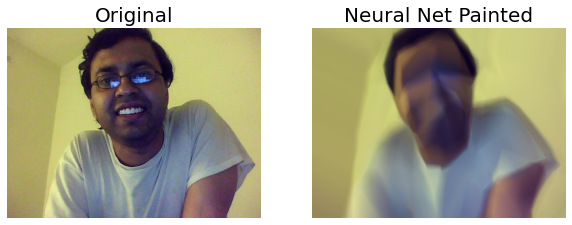

In [14]:
m.fit(x, y, batch_size=5, epochs=10, verbose=1, validation_data=(x, y))
out = generate_image(m, x, im.width, im.height)

plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(im), plt.axis('off'), plt.title('Original', size=20)
plt.subplot(122), plt.imshow(out), plt.axis('off'), plt.title('Neural Net Painted', size=20)
plt.show()

### Problem 6: Semantic Image Inpainting with DCGAN

*Deep convolutional generative adversarial network* (**DCGAN**) introduces certain architectural constraints in the implementation of an ordinary **GAN**, and yields better result with stronger representation learning. It eliminates the fully connected layers (and also the *global average pooling* which hurts the convergence speed) turning it into an *all convolutional net*, replaces deterministic spatial pooling functions (such as maxpooling) with strided convolutions, allowing the *discriminator* and the *generator*, to learn their own *spatial downsampling* and *spatial upsampling*, respectively.

Here are the architecture guidelines for stable *DCGAN* [4]:

* Use *strided convolutions* and *fractional-strided convolutions* instead of the *pooling* layers, for the *discriminator* and the *generator*, respectively.
* Use *batch-normalization* in *generator* & *discriminator* (except for the layers generator output and the discriminator input).
* For deeper architectures get rid of *fully connected hidden layers*.
* For all layers in the *generator*, use the `ReLU` *activation* (except for the output, use `Tanh` activation).
* For all layers in the *discriminator*, use the `LeakyReLU` *activation*.

The next figure shows the *DCGAN generator* architecture:

![](images/dcgan_arch.png)

In this section, we shall learn how to use *DCGAN* for image completion, given a partially corrupted image.

* Semantic image inpainting is a challenging task where large missing regions have to be filled based on the available visual data.
* Given a trained generative model, the closest encoding of the corrupted image is searched in the latent image manifold using the context and prior losses. This encoding is then passed through the generative model to infer the missing content. 
* The inference is possible irrespective of how the missing content is structured.
* *Back-propagation to the input data* is employed in to find the encoding which is close to the provided corrupted image.
* To fill large missing regions in images, our method for image inpainting utilizes the generator $G$ and the discriminator $D$, both of which are trained with uncorrupted data. The encoding $\hat{z}$ **closest** to the corrupted image is recovered while being constrained to the manifold, as shown in the next figure. After $\hat{z}$ is obtained, the missing content can be generated by using the trained generator [5].

![](images/sem_inpaint.png)

* The process of finding $\hat{z}$ can be formulated as an optimization problem. Let $y$ be the corrupted image and $M$ be the binary mask with size equal to the image, to indicate the missing parts. The *closest* encoding $\hat{z}$ is defined as:

![](images/dc_loss.png)

* The *context loss* constrains the generated image given the input corrupted image $y$ and the hole mask $M$, whereas the *prior loss* penalizes unrealistic images.

* **Weighted context loss**: To fill large missing regions, we need to take advantage of the remaining available data. The context loss is designed to capture such information. A convenient choice for the context loss is simply the $\mathbb{l}_2$ norm between the generated sample $G(z)$ and the uncorrupted portion of the input image $y$, but such a loss treats each pixel equally, which is not desired.

* A context loss is to be defined with the hypothesis that the importance of an uncorrupted pixel is positively correlated with the number of corrupted pixels surrounding it. A pixel that is very far away from any holes plays very little role in the inpainting process. This intuition is captured with the importance weighting term, $W$ defined as follows:

![](images/con_loss.png)

* After generating $G(\hat{z})$, the inpainting result can be obtained by overlaying the uncorrupted pixels from the
input. However, the predicted pixels may not exactly preserve the same intensities of the surrounding pixels, which is corrected using *Poisson blending* (by keeping the gradients of $G(\hat{z})$ to preserve image details while shifting the color to match the color in the input image $y$. The final solution, recovered image $\hat{x}$, can be obtained by:

![](images/sem_opt.png)

* In this section, we shall use a pretrained *DCGAN* model with `tensorflow` (with `v1`), trained on celebrity faces (`celebA` daatset).

* Let's start by importing the required libraries, with the following code snippet.

In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pylab as plt
from glob import glob
from skimage.io import imread
from scipy.signal import convolve2d

In [8]:
def gen_mask(img_sz = 64, scale = 0.25):    
    image_shape = [img_sz, img_sz]
    mask = np.ones(image_shape)
    #assert(scale <= 0.5)
    mask = np.ones(image_shape)
    l = int(img_sz*scale)
    u = int(img_sz*(1.0-scale))
    mask[l:u, l:u] = 0.0
    return mask

imgfilenames = sorted(glob('images/faces' + '/*.png'))
images = np.array([imread(f, pilmode='RGB').astype('float') for f in imgfilenames]).astype(np.uint8)

masked_images = images.copy()
mask = gen_mask()
mask = (255*mask).astype(np.uint8)
for i in range(len(images)):
    masked_images[i,...] = masked_images[i,...] & np.expand_dims(mask,2)
masked_images = masked_images.astype(np.float64)
mask = (mask / 255).astype(np.float64)

In [23]:
def loadpb(filename, model_name='dcgan'):
    with tf.io.gfile.GFile(filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def,
                            input_map=None,
                            return_elements=None,
                            op_dict=None,
                            producer_op_list=None,
                            name=model_name)
    return graph, graph_def

model_name = 'dcgan'
gen_input, gen_output, gen_loss = 'z:0', 'Tanh:0', 'Mean_2:0'
graph, graph_def = loadpb('models/dcgan-100.pb', model_name)

gi = graph.get_tensor_by_name(model_name+'/' + gen_input)
go = graph.get_tensor_by_name(model_name+'/' + gen_output)
gl = graph.get_tensor_by_name(model_name+'/' + gen_loss)
image_shape = go.shape[1:].as_list()

In [29]:
def create_weighted_mask(mask, nsize=7):
    ker = np.ones((nsize,nsize), dtype=np.float32)
    ker = ker/np.sum(ker)
    wmask = mask * convolve2d(1-mask, ker, mode='same', boundary='symm')
    return wmask

def binarize_mask(mask, dtype=np.float32):
    assert(np.dtype(dtype) == np.float32 or np.dtype(dtype) == np.uint8)
    bmask = np.array(mask, dtype=np.float32)
    bmask[bmask>0] = 1.0
    bmask[bmask<=0] = 0
    if dtype == np.uint8:
        bmask = np.array(bmask*255, dtype=np.uint8)
    return bmask

def create_3_channel_mask(mask):
    return np.repeat(mask[:,:,np.newaxis], 3, axis=2)

def build_restore_graph(graph):
    image_shape = go.shape[1:].as_list()
    with graph.as_default():
        masks = tf.placeholder(tf.float32, [None] + image_shape, name='mask')
        images = tf.placeholder(tf.float32, [None] + image_shape, name='images')
        x = tf.abs(tf.multiply(masks, go) - tf.multiply(masks, images))
        context_loss = tf.reduce_sum(tf.reshape(x, (tf.shape(x)[0], -1)), 1)
        perceptual_loss = gl
        inpaint_loss = context_loss + l*perceptual_loss
        inpaint_grad = tf.gradients(inpaint_loss, gi)
    return inpaint_loss, inpaint_grad, masks, images

def preprocess(images, imask, useWeightedMask=True, batch_size=64, nsize=15):
    images = images / 127.5-1
    mask = create_3_channel_mask(create_weighted_mask(imask, nsize))
    bin_mask = create_3_channel_mask(binarize_mask(imask, dtype='uint8'))
    masks_data = np.repeat(mask[np.newaxis, :, :, :], batch_size, axis=0)
    num_images = images.shape[0]
    images_data = np.repeat(images[np.newaxis, 0, :, :, :], batch_size, axis=0)
    ncpy = min(num_images, batch_size)
    images_data[:ncpy, :, :, :] = images[:ncpy, :, :, :].copy()
    return masks_data, images_data  
    
def postprocess(g_out, images_data, masks_data):
    images_out = (np.array(g_out) + 1.0) / 2.0
    images_in = (np.array(images_data) + 1.0) / 2.0
    images_out = np.multiply(images_out, 1-masks_data) + np.multiply(images_in, masks_data)
    return images_out

In [31]:
def backprop_to_input(sess, inpaint_loss, inpaint_grad, 
                      masks, images, masks_data, images_data, z, 
                      niter=200, verbose=True):    
    momentum, lr = 0.9, 0.01
    v = 0
    for i in range(niter): 
        out_vars = [inpaint_loss, inpaint_grad, go]
        in_dict = {masks: masks_data, gi: z, images: images_data}
        loss, grad, imout = sess.run(out_vars, feed_dict=in_dict)
        v_prev = np.copy(v)
        v = momentum*v - lr*grad[0]
        z += (-momentum * v_prev + (1 + momentum) * v)
        z = np.clip(z, -1, 1)
        if verbose:
            if i % 10 == 0:
                print('Iteration {}: {}'.format(i, np.mean(loss)))        
    return imout

def restore_image(images, masks, graph, sess):
    masks_data, images_data = preprocess(images, masks)
    inpaint_loss, inpaint_grad, masks, images = build_restore_graph(graph)
    imout = backprop_to_input(sess, inpaint_loss, inpaint_grad, masks, images, masks_data, images_data, z)
    return postprocess(imout, images_data, masks_data), images_data, imout

batch_size, z_dim = 64, 100
z = np.random.randn(batch_size, z_dim)
sess = tf.Session(graph=graph)
inpaint_out, images_data, imout = restore_image(masked_images, mask, graph, sess)

Iteration 0: 221.28106689453125
Iteration 10: 137.1205291748047
Iteration 20: 120.86093139648438
Iteration 30: 120.55803680419922
Iteration 40: 118.15397644042969
Iteration 50: 111.87590026855469
Iteration 60: 111.30235290527344
Iteration 70: 109.60200500488281
Iteration 80: 112.72096252441406
Iteration 90: 108.38629150390625
Iteration 100: 106.88809204101562
Iteration 110: 106.95480346679688
Iteration 120: 106.71363830566406
Iteration 130: 105.97818756103516
Iteration 140: 103.75382995605469
Iteration 150: 101.30975341796875
Iteration 160: 104.94699096679688
Iteration 170: 101.54997253417969
Iteration 180: 107.21031951904297
Iteration 190: 103.7147445678711


![](images/sem_inpainting.png)

### Questions

1. A very simple Blur function: Implement a `python` function `get_custom_blurkernel()` to simulate a custom motion motion-blur kernel. Implement another function `gen_blurred_image()` that accepts an `input` and an `output` image file and your custom `blur` function, reads the input image file, applies the blur kernel (by invoking the `blur` function passed as argument) to the input image and saves the output in the output image file. Plot the input image, the generated kernel and the blurred output image. 

    For example, if you want to generate your blur-kernel with a cubic spline (to obtain the blur kernel used to create the blurred input for **DeblurGAN**), you just need to call 

    `gen_blurred_image(path_to_input_img, path_to_save_blurred_img, get_custom_blurkernel)` 

    and the output will look like the one shown in the following figure.
    
    ![](images/spline_blur.png)

    Now, implement the *motion blur kernel generation* algorithm from the paper *https://arxiv.org/pdf/1711.07064.pdf*. Blur an image with the function you implemented and apply DeblurGAN to obtain the sharpened version of the image.
    
    
2. In the chapter, we used available pre-trained weights `GCANet` and `DeblurGAN` deep learning models. Now let's train the models on custom annotated images (you will need hazy / blurred and clean version of every image in the training dataset) to be used for dehazing and deblurring, respectively. 

   Note that you can **train** a deep neural net model 
    * **partially** (using **transfer learning**), by training the weights of last few layers only (preferably when you have smallerer number of annotated training images), or, 
    * **fully** (**from scratch**) when you have a whole lot of annotated images.

  In any case, or training a very deep learning model, you will need a *GPU* for faster training (use *google colab*).
  

3. Use `opencv-python`'s `bm3d` implementation (the function `cv2.xphoto.bm3dDenoising()`) for denoising (note that the algorithm is patented, you need to build `opencv` with an appropriate flag). 

   ![](images/denoised_out.png)


4. Use `kNN` regressor to inpaint the following RGB color image with the given binary mask. You should obtain a figure like the following one:
   ![](images/inpaint_knn_out.png)

### References

1. https://arxiv.org/pdf/1606.08921.pdf
2. https://arxiv.org/pdf/1711.07064.pdf
3. https://arxiv.org/pdf/1811.08747.pdf
4. https://arxiv.org/pdf/1511.06434.pdf
5. https://arxiv.org/pdf/1607.07539.pdf
6. https://authors.library.caltech.edu/6498/1/PERieeetpami90.pdf
7. https://aip.scitation.org/doi/pdf/10.1063/1.4887563
8. https://github.com/cddlyf/GCANet
9. https://github.com/aizvorski/video-quality/blob/d16674a14c66d9014ac82fcb7925dbc86e568d7e/ssim.py 
10. https://www.youtube.com/watch?v=XOcCXvksbTI